In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
batch_size = 32
img_height = 256
img_width = 256

data_dir = os.path.join('..', 'data', 'archive', 'v_2')

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 16000 files belonging to 4 classes.
Using 12800 files for training.
Found 16000 files belonging to 4 classes.
Using 3200 files for validation.


In [4]:
class_names = train_ds.class_names
class_names

['agri', 'barrenland', 'grassland', 'urban']

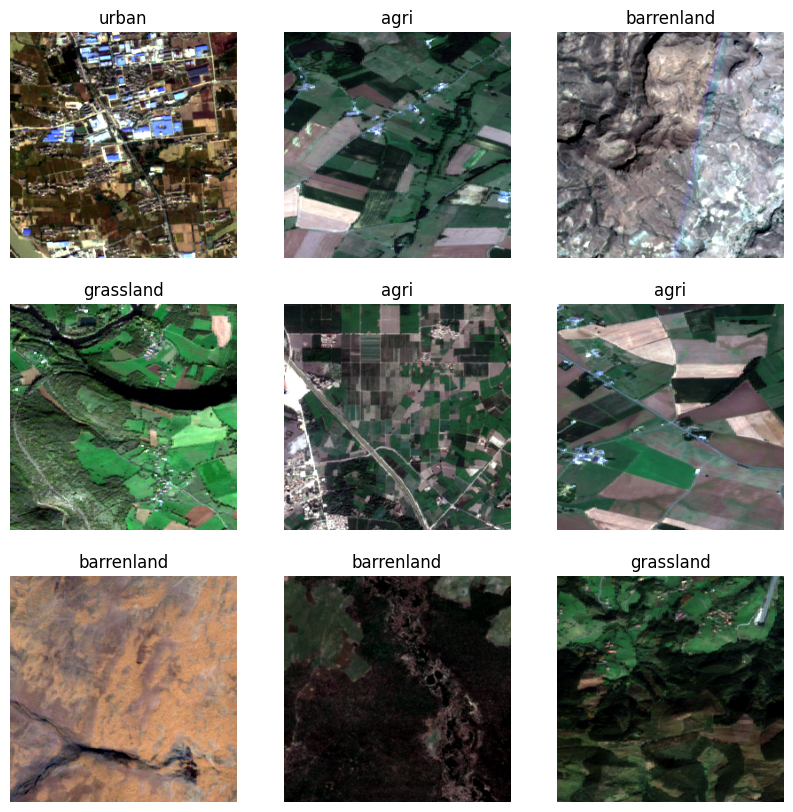

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [6]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
normalization_layer = layers.Rescaling(1./255)

In [9]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.86666673


In [11]:
num_classes = len(class_names)

model = Sequential([
    keras.Input(shape=(img_height, img_width, 3)),
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 256, 256, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 128, 128, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 128, 128, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       8,388,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,412,836 (32.09 MB)

 Trainable params: 8,412,836 (32.09 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 118s 291ms/step - accuracy: 0.7281 - loss: 0.7144 - val_accuracy: 0.9350 - val_loss: 0.1996
Epoch 2/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 121s 303ms/step - accuracy: 0.9421 - loss: 0.1756 - val_accuracy: 0.9553 - val_loss: 0.1399
Epoch 3/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 122s 304ms/step - accuracy: 0.9716 - loss: 0.0840 - val_accuracy: 0.9678 - val_loss: 0.0915
Epoch 4/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 111s 279ms/step - accuracy: 0.9857 - loss: 0.0519 - val_accuracy: 0.9472 - val_loss: 0.1457
Epoch 5/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 115s 286ms/step - accuracy: 0.9884 - loss: 0.0364 - val_accuracy: 0.9581 - val_loss: 0.1219
Epoch 6/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 113s 284ms/step - accuracy: 0.9919 - loss: 0.0243 - val_accuracy: 0.9722 - val_loss: 0.0873
Epoch 7/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 114s 285ms/step - accuracy: 0.9958 - loss: 0.0181 - val_accuracy: 0.9650 - val_loss: 0.1236
Epoch 8/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 115s 288ms/step - accuracy: 0.9959 -

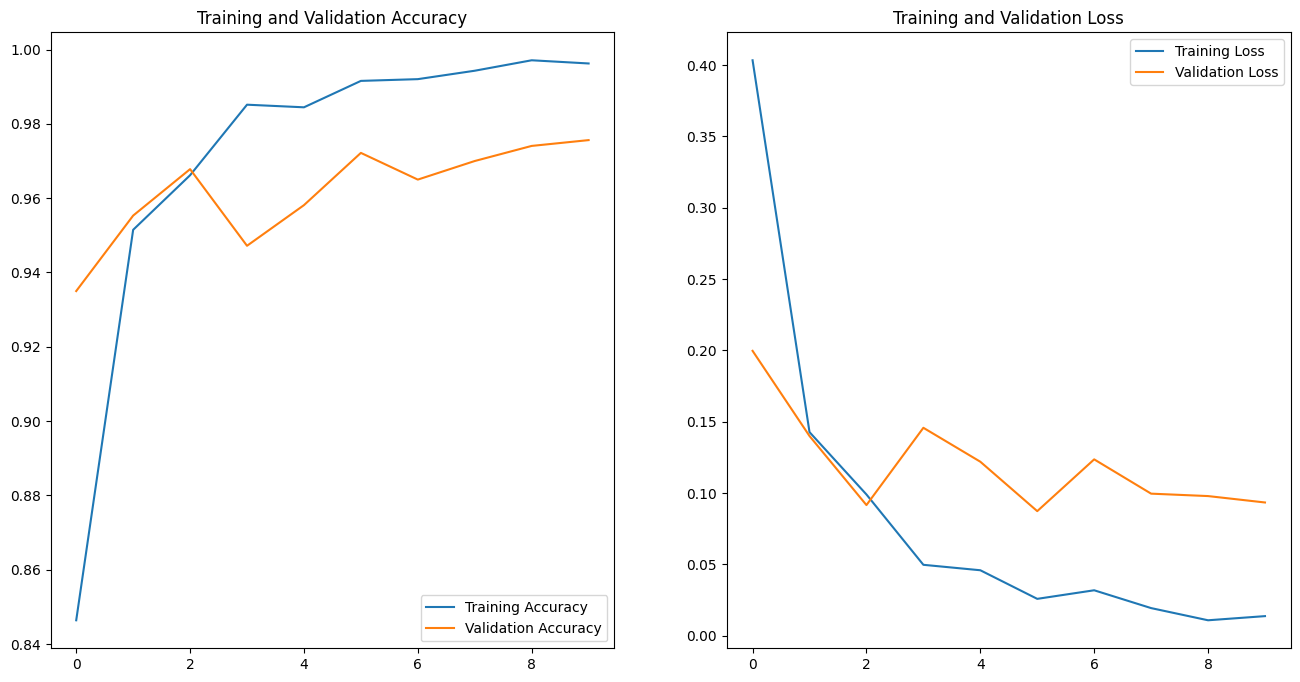

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [19]:
model.save(os.path.join('..', 'models', 'classification-v2.keras'))